Device: cuda
Detected classes: ['0', '1', '2', '3', '4']
Train counts: {0: np.int64(2286), 1: np.int64(1046), 2: np.int64(1516), 3: np.int64(757), 4: np.int64(173)}


C:\Users\vaijais\AppData\Local\Temp\ipykernel_5908\3175881196.py:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == "cuda"))


Training for up to 30 epochs ...


C:\Users\vaijais\AppData\Local\Temp\ipykernel_5908\3175881196.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):


Epoch 01/30 | Train 1.1192/0.5104 | Val 1.0500/0.5157 [*saved*]
Epoch 02/30 | Train 0.7500/0.6636 | Val 0.9659/0.5678 [*saved*]
Epoch 03/30 | Train 0.6331/0.7250 | Val 0.9006/0.6065 [*saved*]
Epoch 04/30 | Train 0.5884/0.7369 | Val 0.9428/0.5630 
Epoch 05/30 | Train 0.5442/0.7696 | Val 0.8708/0.6356 [*saved*]
Epoch 06/30 | Train 0.4904/0.7966 | Val 0.9228/0.6368 [*saved*]
Epoch 07/30 | Train 0.4606/0.8169 | Val 0.9907/0.5787 
Epoch 08/30 | Train 0.4016/0.8404 | Val 1.0863/0.6102 
Epoch 09/30 | Train 0.3736/0.8487 | Val 0.9843/0.6332 
Epoch 10/30 | Train 0.3068/0.8877 | Val 1.0550/0.6392 [*saved*]
Epoch 11/30 | Train 0.2644/0.8989 | Val 1.1059/0.6174 
Epoch 12/30 | Train 0.2450/0.9069 | Val 1.0708/0.6622 [*saved*]
Epoch 13/30 | Train 0.2047/0.9245 | Val 1.2150/0.6211 
Epoch 14/30 | Train 0.2010/0.9292 | Val 1.3056/0.5581 
Epoch 15/30 | Train 0.1565/0.9429 | Val 1.2500/0.6005 
Epoch 16/30 | Train 0.1285/0.9543 | Val 1.3350/0.6162 
Epoch 17/30 | Train 0.1122/0.9614 | Val 1.3278/0.6332 
Ep

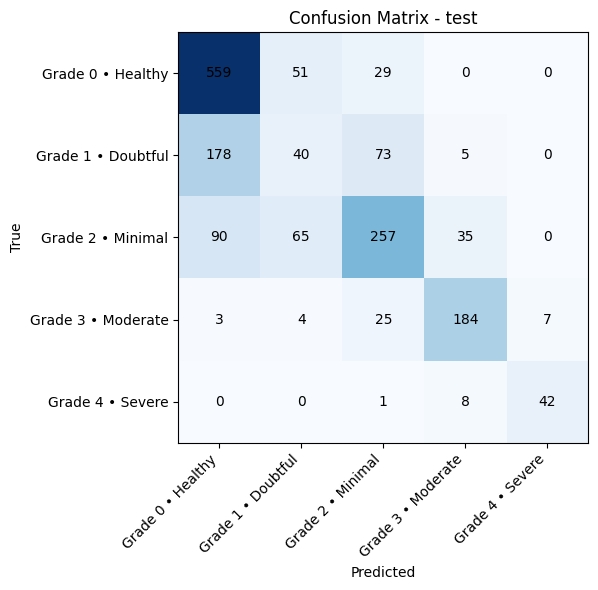

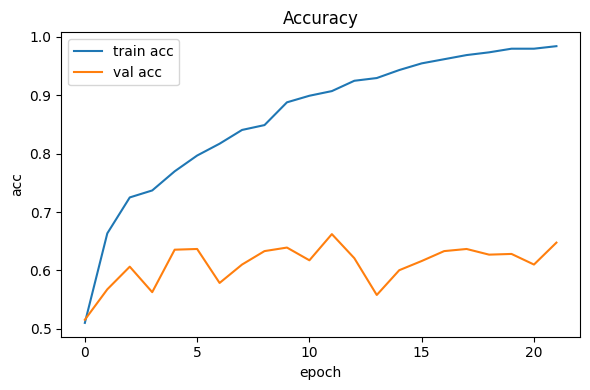

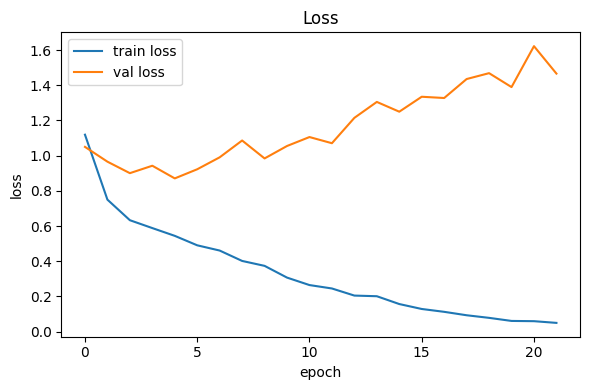

In [11]:
# ====================== Knee X-ray (Grades 0-4) - ResNet50 GPU/AMP ======================
import os, copy, random, time
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ---------------- CONFIG (edit paths as needed) ----------------
TRAIN_DIR = r"C:\Users\vaijais\OneDrive\Desktop\CS666_PROOOJECT_PROOPOOSAL\KNEEDATAXRAY\train"
VAL_DIR   = r"C:\Users\vaijais\OneDrive\Desktop\CS666_PROOOJECT_PROOPOOSAL\KNEEDATAXRAY\val"
TEST_DIR  = r"C:\Users\vaijais\OneDrive\Desktop\CS666_PROOOJECT_PROOPOOSAL\KNEEDATAXRAY\test"

IMG_SIZE     = 224
BATCH_SIZE   = 32        # try 64 on GPU; drop to 16 if OOM
NUM_WORKERS  = 4         # if Windows issues, set 2 or 0
EPOCHS       = 30
LR           = 1e-4
WEIGHT_DECAY = 1e-4
FREEZE_BACKBONE_FIRST = 0   # set >0 to warmup with frozen backbone for N epochs, then unfreeze
PATIENCE     = 10            # early stopping patience (epochs w/o val improvement)
SAVE_PATH    = "kneexray_resnet50_best.pt"
SEED         = 42
# ---------------------------------------------------------------

# Reproducibility
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# Device & backend
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    torch.backends.cudnn.benchmark = True  # speed up on fixed img sizes
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler(enabled=(device.type == "cuda"))

# Transforms: X-rays -> 3 channels + light aug on train
train_tfms = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])
eval_tfms = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

# Datasets
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
val_ds   = datasets.ImageFolder(VAL_DIR,   transform=eval_tfms)
test_ds  = datasets.ImageFolder(TEST_DIR,  transform=eval_tfms)
classes  = train_ds.classes
num_classes = len(classes)
print("Detected classes:", classes)

# Imbalance handling: WeightedRandomSampler on train
targets = np.array(train_ds.targets)
counts  = np.bincount(targets, minlength=num_classes)
weights = 1.0 / np.clip(counts, 1, None)
sample_weights = weights[targets]
sampler = WeightedRandomSampler(sample_weights.tolist(), num_samples=len(sample_weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=(device.type=="cuda"),
                          persistent_workers=(NUM_WORKERS>0))
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(device.type=="cuda"),
                          persistent_workers=(NUM_WORKERS>0))
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(device.type=="cuda"),
                          persistent_workers=(NUM_WORKERS>0))

# Readable labels for report
grade_map = {
    0: "Grade 0 • Healthy",
    1: "Grade 1 • Doubtful",
    2: "Grade 2 • Minimal",
    3: "Grade 3 • Moderate",
    4: "Grade 4 • Severe",
}
label_names = [grade_map.get(i, str(i)) for i in range(num_classes)]
print("Train counts:", dict(zip(range(num_classes), counts)))

# Model: ResNet-50 (ImageNet init)
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
if FREEZE_BACKBONE_FIRST > 0:
    for p in model.parameters():
        p.requires_grad = False
# new classifier
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
opt = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WEIGHT_DECAY)
sched = CosineAnnealingLR(opt, T_max=EPOCHS)

# ------- utils -------
def run_epoch(loader, train=True):
    model.train(mode=train)
    total_loss, correct, total = 0.0, 0, 0
    all_preds, all_true = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            opt.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(train):
            if device.type == "cuda":
                with autocast(dtype=torch.float16):
                    out = model(xb)
                    loss = criterion(out, yb)
            else:
                out = model(xb)
                loss = criterion(out, yb)

            if train:
                if device.type == "cuda":
                    scaler.scale(loss).backward()
                    scaler.step(opt)
                    scaler.update()
                else:
                    loss.backward()
                    opt.step()

        total_loss += loss.item() * xb.size(0)
        preds = out.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
        all_preds.append(preds.detach().cpu().numpy())
        all_true.append(yb.detach().cpu().numpy())

    return total_loss/total, correct/total, np.concatenate(all_preds), np.concatenate(all_true)

# ------- (optional) unfreeze after warmup -------
def unfreeze_backbone_if_needed(epoch_idx):
    if FREEZE_BACKBONE_FIRST > 0 and epoch_idx == FREEZE_BACKBONE_FIRST:
        print(f"\nUnfreezing backbone at epoch {epoch_idx} ...")
        for p in model.parameters():
            p.requires_grad = True
        # re-create optimizer to include all params
        global opt
        opt = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# ------- training with early stopping -------
history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}
best_val, best_state, no_improve = 0.0, None, 0

print(f"Training for up to {EPOCHS} epochs ...")
for ep in range(1, EPOCHS+1):
    unfreeze_backbone_if_needed(ep-1)

    tr_loss, tr_acc, _, _ = run_epoch(train_loader, True)
    va_loss, va_acc, _, _ = run_epoch(val_loader, False)
    sched.step()

    history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)

    improved = va_acc > best_val
    if improved:
        best_val, best_state, no_improve = va_acc, copy.deepcopy(model.state_dict()), 0
        torch.save(best_state, SAVE_PATH)
    else:
        no_improve += 1

    print(f"Epoch {ep:02d}/{EPOCHS} | Train {tr_loss:.4f}/{tr_acc:.4f} | Val {va_loss:.4f}/{va_acc:.4f} "
          f"{'[*saved*]' if improved else ''}")

    if no_improve >= PATIENCE:
        print(f"Early stopping at epoch {ep} (no val improvement for {PATIENCE} epochs).")
        break

print(f"\nBest validation accuracy: {best_val:.4f} (saved to {SAVE_PATH})")

# ------- Load best and evaluate on TEST -------
if best_state is None and os.path.exists(SAVE_PATH):
    best_state = torch.load(SAVE_PATH, map_location="cpu")
if best_state is not None:
    model.load_state_dict(best_state)
model.eval()

def evaluate(loader, split="test"):
    _, acc, preds, true = run_epoch(loader, False)
    print(f"\n{split.capitalize()} Accuracy: {acc:.4f}")
    print("\nClassification report:")
    print(classification_report(true, preds, target_names=label_names, digits=4))
    cm = confusion_matrix(true, preds)

    # Confusion matrix plot
    plt.figure(figsize=(7,6))
    plt.imshow(cm, cmap="Blues")
    plt.title(f"Confusion Matrix - {split}")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(range(num_classes), label_names, rotation=45, ha="right")
    plt.yticks(range(num_classes), label_names)
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout(); plt.show()

evaluate(test_loader, "test")

# ------- Plot training curves -------
plt.figure(figsize=(6,4))
plt.plot(history["train_acc"], label="train acc"); plt.plot(history["val_acc"], label="val acc")
plt.legend(); plt.title("Accuracy"); plt.xlabel("epoch"); plt.ylabel("acc"); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(history["train_loss"], label="train loss"); plt.plot(history["val_loss"], label="val loss")
plt.legend(); plt.title("Loss"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.tight_layout(); plt.show()
# ====================== end script ======================


In [9]:
from ultralytics import YOLO

DATA_ROOT = r"C:\Users\vaijais\OneDrive\Desktop\KNEEDATAXRAY"

# Choose the YOLOv8 classification model (n=small, m=medium, l=large)
MODEL = "yolov8m-cls.pt"  
DEVICE = 0  

# Load the model
model = YOLO(MODEL)

# Train the classifier
results = model.train(
    data=DATA_ROOT,
    epochs=30,
    imgsz=224,
    batch=64,
    device=DEVICE,
    patience=8,
    lr0=1e-3,
    weight_decay=5e-4,
    augment=True,
    mixup=0.1,
    cutmix=0.2,
    dropout=0.1,
    project="runs/classify",
    name="kneexray_yolov8m",
)


New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.225  Python-3.9.25 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.2, data=C:\Users\vaijais\OneDrive\Desktop\KNEEDATAXRAY, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8m-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, 

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\ultralytics\nn\modules\block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\ultralytics\nn\modules\block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or 

AMP: checks passed 
train: Fast image access  (ping: 0.00.0 ms, read: 233.031.6 MB/s, size: 19.0 KB)
train: Scanning C:\Users\vaijais\OneDrive\Desktop\KNEEDATAXRAY\train... 5778 images, 0 corrupt: 100% ━━━━━━━━━━━━ 5778/5778 8.3Kit/s 0.7s0.1s
train: New cache created: C:\Users\vaijais\OneDrive\Desktop\KNEEDATAXRAY\train.cache
val: Fast image access  (ping: 0.00.0 ms, read: 314.2102.0 MB/s, size: 22.2 KB)
val: Scanning C:\Users\vaijais\OneDrive\Desktop\KNEEDATAXRAY\val... 826 images, 0 corrupt: 100% ━━━━━━━━━━━━ 826/826 4.0Kit/s 0.2s0.0s
val: New cache created: C:\Users\vaijais\OneDrive\Desktop\KNEEDATAXRAY\val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 38 weight(decay=0.0), 39 weight(decay=0.0005), 39 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to C:\Users\vaijais\

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       1/30     0.992G      1.398         18        224: 100% ━━━━━━━━━━━━ 91/91 5.4it/s 16.8s0.2s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 4.3it/s 1.6s0.3ss
                   all      0.492          1

      Epoch    GPU_mem       loss  Instances       Size
       2/30      2.88G      1.355         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       2/30      2.88G      1.115         18        224: 100% ━━━━━━━━━━━━ 91/91 8.2it/s 11.1s0.2s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.6it/s 0.5s.1s
                   all      0.593          1

      Epoch    GPU_mem       loss  Instances       Size
       3/30      3.39G      1.057         64        224: 0% ──────────── 0/91  0.2s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       3/30      3.39G      1.019         18        224: 100% ━━━━━━━━━━━━ 91/91 8.0it/s 11.3s0.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.9it/s 0.5s.1s
                   all      0.541          1

      Epoch    GPU_mem       loss  Instances       Size
       4/30      3.39G      1.013         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       4/30      3.39G     0.9965         18        224: 100% ━━━━━━━━━━━━ 91/91 8.0it/s 11.4s0.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 15.3it/s 0.5s.1s
                   all      0.609          1

      Epoch    GPU_mem       loss  Instances       Size
       5/30      3.39G     0.9443         64        224: 0% ──────────── 0/91  0.2s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       5/30      3.39G     0.9574         18        224: 100% ━━━━━━━━━━━━ 91/91 7.6it/s 11.9s0.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.1it/s 0.5s.1s
                   all      0.627          1

      Epoch    GPU_mem       loss  Instances       Size
       6/30      3.39G      1.002         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       6/30      3.39G     0.9266         18        224: 100% ━━━━━━━━━━━━ 91/91 7.9it/s 11.6s0.2s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 15.2it/s 0.5s.1s
                   all       0.66          1

      Epoch    GPU_mem       loss  Instances       Size
       7/30      3.39G      1.048         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       7/30      3.39G     0.9079         18        224: 100% ━━━━━━━━━━━━ 91/91 8.2it/s 11.2s0.2s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.9it/s 0.5s.1s
                   all       0.62          1

      Epoch    GPU_mem       loss  Instances       Size
       8/30      3.39G     0.7924         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       8/30      3.39G     0.8959         18        224: 100% ━━━━━━━━━━━━ 91/91 7.9it/s 11.5s0.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.8it/s 0.5s.1s
                   all      0.643          1

      Epoch    GPU_mem       loss  Instances       Size
       9/30      3.39G      1.035         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       9/30      3.39G     0.8712         18        224: 100% ━━━━━━━━━━━━ 91/91 8.0it/s 11.3s0.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.7it/s 0.5s.1s
                   all      0.633          1

      Epoch    GPU_mem       loss  Instances       Size
      10/30      3.39G     0.7716         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      10/30      3.39G     0.8337         18        224: 100% ━━━━━━━━━━━━ 91/91 7.8it/s 11.7s0.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.2it/s 0.5s.1s
                   all       0.65          1

      Epoch    GPU_mem       loss  Instances       Size
      11/30      3.39G     0.7276         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      11/30      3.39G     0.8525         18        224: 100% ━━━━━━━━━━━━ 91/91 7.9it/s 11.5s0.2s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.8it/s 0.5s.1s
                   all      0.615          1

      Epoch    GPU_mem       loss  Instances       Size
      12/30      3.39G     0.8283         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      12/30      3.39G     0.8315         18        224: 100% ━━━━━━━━━━━━ 91/91 8.0it/s 11.4s0.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.6it/s 0.5s.1s
                   all      0.659          1

      Epoch    GPU_mem       loss  Instances       Size
      13/30      3.39G     0.7707         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      13/30      3.39G     0.8166         18        224: 100% ━━━━━━━━━━━━ 91/91 7.9it/s 11.5s0.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.7it/s 0.5s.1s
                   all      0.669          1

      Epoch    GPU_mem       loss  Instances       Size
      14/30      3.39G       1.01         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      14/30      3.39G     0.7956         18        224: 100% ━━━━━━━━━━━━ 91/91 7.9it/s 11.5s0.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.5it/s 0.5s.1s
                   all      0.651          1

      Epoch    GPU_mem       loss  Instances       Size
      15/30      3.39G     0.9475         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      15/30      3.39G     0.7815         18        224: 100% ━━━━━━━━━━━━ 91/91 7.8it/s 11.6s0.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.8it/s 0.5s.1s
                   all      0.644          1

      Epoch    GPU_mem       loss  Instances       Size
      16/30      3.39G     0.6889         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      16/30      3.39G     0.7815         18        224: 100% ━━━━━━━━━━━━ 91/91 8.0it/s 11.4s0.2s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.6it/s 0.5s.1s
                   all      0.666          1

      Epoch    GPU_mem       loss  Instances       Size
      17/30      3.39G     0.7413         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      17/30      3.39G     0.7497         18        224: 100% ━━━━━━━━━━━━ 91/91 7.8it/s 11.6s0.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.5it/s 0.5s.1s
                   all      0.661          1

      Epoch    GPU_mem       loss  Instances       Size
      18/30      3.39G     0.6646         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      18/30      3.39G     0.7662         18        224: 100% ━━━━━━━━━━━━ 91/91 7.9it/s 11.5s0.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.8it/s 0.5s.1s
                   all      0.669          1

      Epoch    GPU_mem       loss  Instances       Size
      19/30      3.39G     0.8228         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      19/30      3.39G     0.7444         18        224: 100% ━━━━━━━━━━━━ 91/91 8.0it/s 11.4s0.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.6it/s 0.5s.1s
                   all      0.671          1

      Epoch    GPU_mem       loss  Instances       Size
      20/30      3.39G     0.6587         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      20/30      3.39G     0.7222         18        224: 100% ━━━━━━━━━━━━ 91/91 7.9it/s 11.5s0.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.7it/s 0.5s.1s
                   all      0.632          1

      Epoch    GPU_mem       loss  Instances       Size
      21/30      3.39G     0.8319         64        224: 0% ──────────── 0/91  0.4s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      21/30      3.39G      0.709         18        224: 100% ━━━━━━━━━━━━ 91/91 7.8it/s 11.7s0.2s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.9it/s 0.5s.1s
                   all      0.677          1

      Epoch    GPU_mem       loss  Instances       Size
      22/30      3.39G     0.5438         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      22/30      3.39G     0.6786         18        224: 100% ━━━━━━━━━━━━ 91/91 8.0it/s 11.4s0.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.7it/s 0.5s.1s
                   all       0.65          1

      Epoch    GPU_mem       loss  Instances       Size
      23/30      3.39G     0.7681         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      23/30      3.39G      0.676         18        224: 100% ━━━━━━━━━━━━ 91/91 8.0it/s 11.3s0.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.8it/s 0.5s.1s
                   all      0.654          1

      Epoch    GPU_mem       loss  Instances       Size
      24/30      3.39G     0.7619         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      24/30      3.39G      0.648         18        224: 100% ━━━━━━━━━━━━ 91/91 7.9it/s 11.4s0.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.5it/s 0.5s.1s
                   all      0.668          1

      Epoch    GPU_mem       loss  Instances       Size
      25/30      3.39G     0.7746         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      25/30      3.39G      0.644         18        224: 100% ━━━━━━━━━━━━ 91/91 7.9it/s 11.5s0.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.5it/s 0.5s.1s
                   all      0.666          1

      Epoch    GPU_mem       loss  Instances       Size
      26/30      3.39G      0.646         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      26/30      3.39G     0.6159         18        224: 100% ━━━━━━━━━━━━ 91/91 7.9it/s 11.5s0.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.5it/s 0.5s.1s
                   all      0.657          1

      Epoch    GPU_mem       loss  Instances       Size
      27/30      3.39G     0.5392         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      27/30      3.39G       0.61         18        224: 100% ━━━━━━━━━━━━ 91/91 7.9it/s 11.6s0.2s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.5it/s 0.5s.1s
                   all      0.659          1

      Epoch    GPU_mem       loss  Instances       Size
      28/30      3.39G     0.5173         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      28/30      3.39G     0.6057         18        224: 100% ━━━━━━━━━━━━ 91/91 7.9it/s 11.5s0.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.5it/s 0.5s.1s
                   all      0.648          1

      Epoch    GPU_mem       loss  Instances       Size
      29/30      3.39G     0.5201         64        224: 0% ──────────── 0/91  0.1s

C:\Users\vaijais\anaconda3\envs\yolov5\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      29/30      3.39G     0.5714         18        224: 100% ━━━━━━━━━━━━ 91/91 7.8it/s 11.6s0.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 14.4it/s 0.5s.1s
                   all      0.657          1
EarlyStopping: Training stopped early as no improvement observed in last 8 epochs. Best results observed at epoch 21, best model saved as best.pt.
To update EarlyStopping(patience=8) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

29 epochs completed in 0.114 hours.
Optimizer stripped from C:\Users\vaijais\CS666-Labs\runs\classify\kneexray_yolov8m\weights\last.pt, 31.7MB
Optimizer stripped from C:\Users\vaijais\CS666-Labs\runs\classify\kneexray_yolov8m\weights\best.pt, 31.7MB

Validating C:\Users\vaijais\CS666-Labs\runs\classify\kneexray_yolov8m\weights\best.pt...
Ultralytics 8.3.225  Python-3.9.25 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
YOLOv8m-cls summary (fused): 42 layers, 15,769,0

ResNet device: cuda
Test classes: ['0', '1', '2', '3', '4']


C:\Users\vaijais\AppData\Local\Temp\ipykernel_5908\512349293.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load(RESNET_WEIGHTS, map_locat

ResNet prob shape: (1656, 5)
YOLO prob shape: (1656, 5)

ResNet Test Accuracy : 0.6244
YOLOv8 Test Accuracy : 0.6908
Hybrid Test Accuracy : 0.7029

Hybrid Classification Report:
                    precision    recall  f1-score   support

 Grade 0 • Healthy     0.6936    0.9390    0.7979       639
Grade 1 • Doubtful     0.3723    0.1182    0.1795       296
 Grade 2 • Minimal     0.6871    0.6779    0.6824       447
Grade 3 • Moderate     0.8873    0.8117    0.8478       223
  Grade 4 • Severe     0.8654    0.8824    0.8738        51

          accuracy                         0.7029      1656
         macro avg     0.7011    0.6858    0.6763      1656
      weighted avg     0.6658    0.7029    0.6652      1656



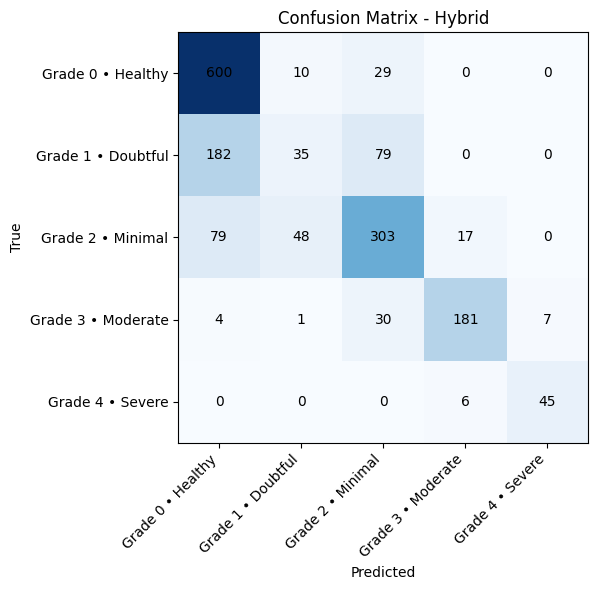

In [17]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import torch.nn as nn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ==================== CONFIG ====================
DATA_ROOT = r"C:\Users\vaijais\OneDrive\Desktop\CS666_PROOOJECT_PROOPOOSAL\KNEEDATAXRAY"
TEST_DIR  = os.path.join(DATA_ROOT, "test")

RESNET_WEIGHTS = "kneexray_resnet50_best.pt"
YOLO_WEIGHTS   = r"C:\Users\vaijais\runs\classify\kneexray_yolov8m_medical\weights\best.pt"

IMG_SIZE   = 320          # match YOLO training size
BATCH_SIZE = 32
NUM_WORKERS = 4
ALPHA = 0.3                # best from validation (70% ResNet, 30% YOLO)

# ResNet on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("ResNet device:", device)

# Force YOLO to run on CPU (avoid CUDA OOM during prediction)
YOLO_DEVICE = "cpu"

# ==================== DATA ====================
eval_tfms = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

test_ds = datasets.ImageFolder(TEST_DIR, transform=eval_tfms)
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda")
)

classes = test_ds.classes
num_classes = len(classes)

grade_map = {
    0: "Grade 0 • Healthy",
    1: "Grade 1 • Doubtful",
    2: "Grade 2 • Minimal",
    3: "Grade 3 • Moderate",
    4: "Grade 4 • Severe",
}
label_names = [grade_map.get(i, str(i)) for i in range(num_classes)]
print("Test classes:", classes)

test_paths = [s[0] for s in test_ds.samples]
test_labels = np.array([s[1] for s in test_ds.samples])

# ==================== LOAD RESNET ====================
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
resnet.load_state_dict(torch.load(RESNET_WEIGHTS, map_location=device))
resnet = resnet.to(device)
resnet.eval()

@torch.no_grad()
def predict_resnet_probs(loader):
    all_probs = []
    all_labels = []

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        logits = resnet(xb)
        probs = torch.softmax(logits, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_labels.append(yb.cpu().numpy())

    return np.concatenate(all_probs, axis=0), np.concatenate(all_labels, axis=0)

res_probs, res_labels = predict_resnet_probs(test_loader)
assert np.array_equal(res_labels, test_labels)
print("ResNet prob shape:", res_probs.shape)

# Free a bit of GPU cache (optional)
if device.type == "cuda":
    torch.cuda.empty_cache()

# ==================== LOAD YOLOv8 CLASSIFIER (CPU) ====================
yolo = YOLO(YOLO_WEIGHTS)

def predict_yolo_probs(image_paths, imgsz=IMG_SIZE):
    all_probs = []
    chunk_size = 64  # avoid RAM spikes

    for i in range(0, len(image_paths), chunk_size):
        batch_paths = image_paths[i:i + chunk_size]
        results = yolo.predict(
            source=batch_paths,
            imgsz=imgsz,
            device=YOLO_DEVICE,   # run on CPU
            stream=True,
            verbose=False
        )
        for r in results:
            all_probs.append(r.probs.data.cpu().numpy())

    return np.stack(all_probs, axis=0)

yolo_probs = predict_yolo_probs(test_paths)
print("YOLO prob shape:", yolo_probs.shape)

# ==================== HYBRID ENSEMBLE ====================
hybrid_probs = ALPHA * res_probs + (1 - ALPHA) * yolo_probs
hybrid_preds = hybrid_probs.argmax(axis=1)

# ACCURACY
acc_resnet = accuracy_score(test_labels, res_probs.argmax(axis=1))
acc_yolo   = accuracy_score(test_labels, yolo_probs.argmax(axis=1))
acc_hybrid = accuracy_score(test_labels, hybrid_preds)

print(f"\nResNet Test Accuracy : {acc_resnet:.4f}")
print(f"YOLOv8 Test Accuracy : {acc_yolo:.4f}")
print(f"Hybrid Test Accuracy : {acc_hybrid:.4f}")

print("\nHybrid Classification Report:")
print(classification_report(test_labels, hybrid_preds, target_names=label_names, digits=4))

# CONFUSION MATRIX
cm = confusion_matrix(test_labels, hybrid_preds)
plt.figure(figsize=(7,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix - Hybrid")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(num_classes), label_names, rotation=45, ha="right")
plt.yticks(range(num_classes), label_names)
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()
